In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os
import datetime as dt
import numpy as np
from copy import deepcopy
import seaborn as sns
from IPython.display import display

# Load

In [3]:
files = os.listdir("data")
# Sort dates
dates = [dt.datetime.strptime(re.findall(r'\d{4}-\d{2}-\d{2}',f)[0],'%Y-%m-%d') for f in files]
dates = sorted(dates,reverse=False)
dates = [i.strftime('%Y-%m-%d') for i in dates]

dfs_raw = {d: pd.read_csv(f'data/worldometers-{d}.tsv',sep="\t") for d in dates}

# Clean

In [4]:
dfs = deepcopy(dfs_raw)
for df in dfs.values():
    for i in range(1, df.shape[1] - 1):
        # Fill nan in numerical data with 0
        df.iloc[:,i] = df.iloc[:,i].fillna(0)
    # Fill categorical nan with Other
    df.iloc[:,-1] = df.iloc[:,-1].fillna('Other')
    df.iloc[:,0] = df.iloc[:,0].fillna('Other')    

# Overall


## What is the proportion of total deaths by total recovered ?

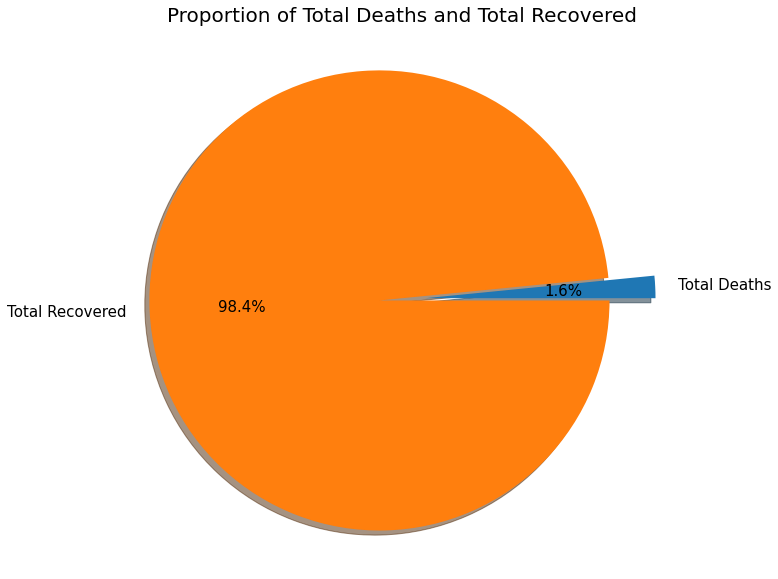

In [5]:
day_deaths = np.fromiter([dfs[i]['TotalDeaths'].sum() for i in dates],dtype= int)
day_recovered = np.fromiter([dfs[i]['TotalRecovered'].sum() for i in dates],dtype= int)
deaths_recovered = [day_deaths.sum(),day_recovered.sum()]


#plot 
fig,ax = plt.subplots(figsize=(10,10)) 
ax.pie(deaths_recovered,
        explode=  (0.1,0.1),
        labels=['Total Deaths','Total Recovered'],
        autopct="%1.1f%%",
        startangle=0 ,
        shadow=True,
        textprops={'fontsize':15})
ax.axis('equal')
ax.set_title('Proportion of Total Deaths and Total Recovered',size=20)
plt.show() 

# Comment:
- On the total number of Recovered and Deaths: 
    - The Total Recovered is overwhelming (98.4%) to the Total Deaths(1.6%) 
    - The conduction of treating and vaccination has take its effect to the recovery of the world 

## What is the trend of Total Deaths and Total Recovered ?

From 03-03-2022 till 18-03-2022:
- Total Deaths keeps its balancing around 6 Million deaths. No sign of significant increase. 
- Total Recovery shows gradually surge day by day.
- The Recovery progress improves why the deaths are halting, which helps the treatment of world easier to back to normal.

/tmp/ipykernel_3159/515310632.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dates,rotation= 50,fontsize=13)
/tmp/ipykernel_3159/515310632.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(dates,rotation= 50,fontsize=13)


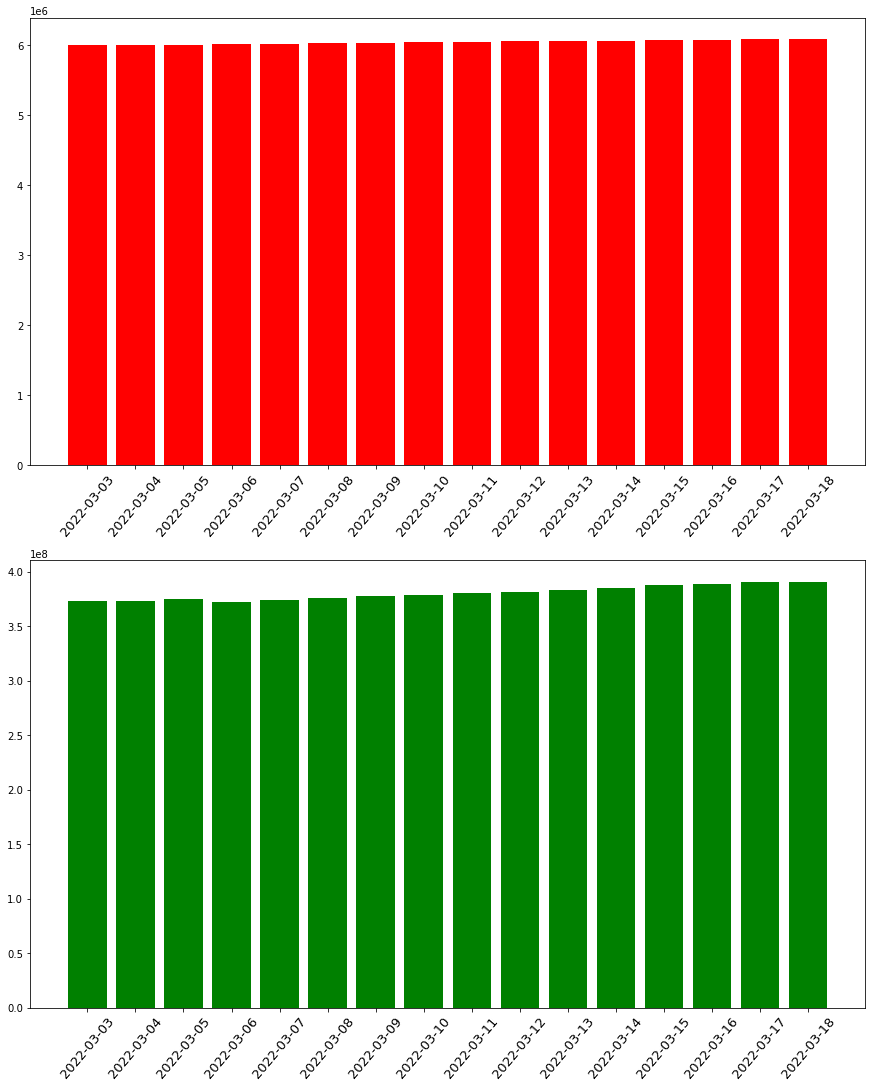

In [6]:
#Histogram to show the trend 
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,15),constrained_layout= True)
ax1.bar(dates,day_deaths,color='r')
ax1.set_xticklabels(dates,rotation= 50,fontsize=13)
ax2.bar(dates,day_recovered,color='g')
ax2.set_xticklabels(dates,rotation= 50,fontsize=13)
plt.show()

## What is the relationship between Total Deaths and Total Recovered 

<Figure size 1080x1440 with 0 Axes>

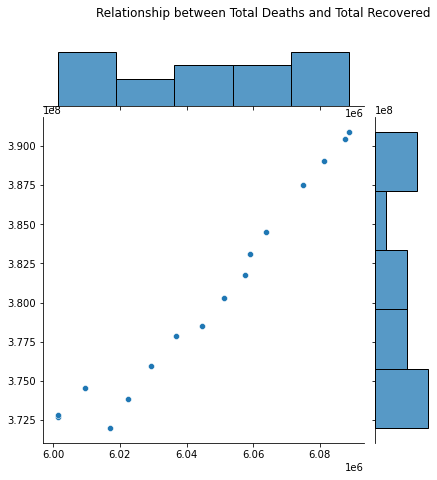

In [31]:
plt.figure(figsize=(15,20))
sns.jointplot(x=day_deaths,y=day_recovered)
plt.title('Relationship between Total Deaths and Total Recovered',pad = 100,loc='Right')
plt.show()

In [10]:
import geoplot 
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [8]:
continents_deaths = dfs[dates[-1]][['Continent','TotalDeaths']].groupby(by=['Continent']).sum()
continents_recovered = dfs[dates[-1]][['Continent','TotalRecovered']].groupby(by='Continent').sum()
new_index = {"Africa":"Africa","Asia":"Asia","Australia/Oceania":"Oceania","Europe":"Europe",
            "North America":"North America",
            "Other":"Antarctica",
            "South America":"South America"
}
continents_deaths.rename(index=new_index,inplace=True)
continents_recovered.rename(index=new_index,inplace=True)


In [9]:
continents_deaths = continents_deaths.reset_index(level= 0)
continents_recovered = continents_recovered.reset_index(level= 0)


In [34]:
map_contients_deaths = pd.merge(world,continents_deaths,left_on='continent',right_on = 'Continent')
map_contients_deaths = map_contients_deaths.dissolve(by='continent',aggfunc='mean')
map_contients_deaths.reset_index(level=0,inplace= True)

map_contients_recovered = pd.merge(world,continents_recovered,left_on='continent',right_on = 'Continent')
map_contients_recovered = map_contients_recovered.dissolve(by='continent',aggfunc='mean')
map_contients_recovered.reset_index(level=0,inplace= True)

# What is the Total Deaths and Total Recovered situation in each continent?

/home/mag/miniconda3/envs/min_ds-env/lib/python3.8/site-packages/geoplot/geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


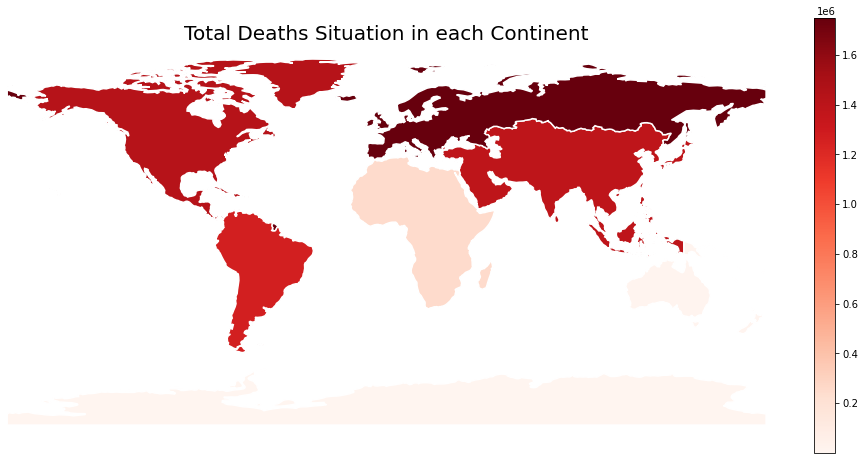

In [36]:
#Choropleht for total deaths in each continent
geoplot.choropleth(map_contients_deaths,
                    hue='TotalDeaths',
                    cmap="Reds",
                    figsize=(17,8),
                    edgecolor='white',
                    linewidth=1.5,
                    legend=True)
plt.title('Total Deaths Situation in each Continent',size=20)
plt.show()

# Comment:
- The area of Europe and Asia have the most serious Deaths : over 1.5 Million Deaths
- The runner-up is North America and South America with about 1.2 - 1.5 Million Deaths
- Africa comes with around 600.000 deaths 
- Oceania and Antarctica suffer less than 400.000 deaths in total

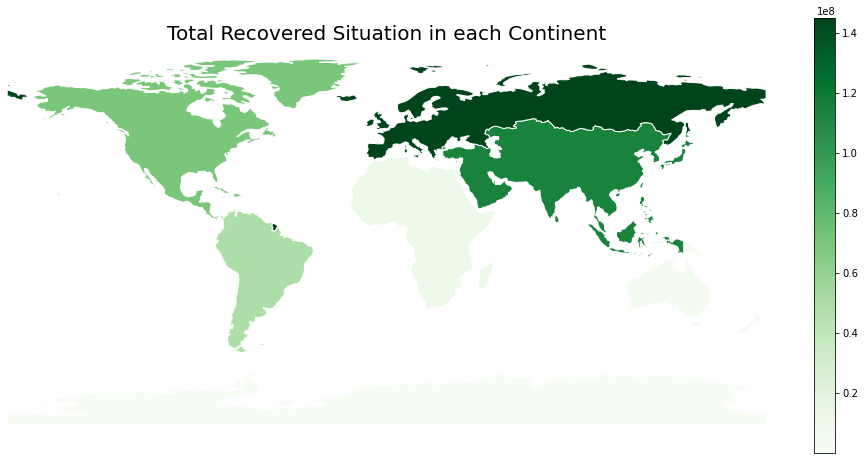

In [37]:
#Choropleth for total recovered in each continent
geoplot.choropleth(map_contients_recovered,
                    hue='TotalRecovered',
                    cmap="Greens",
                    figsize=(17,8),
                    edgecolor='white',
                    legend=True)
plt.title('Total Recovered Situation in each Continent',size=20)
plt.show()


# Comment: 
- While Europe and Asis have the most death cases, their recovery are also the highest. 
- North and South Ameria recovery is the second high like their rank in the total deaths
- Africa's recovery is quite slow compared to their deaths rate.
- Oceania and Antartica have the lowest death cases so the total recovered cases is low, too. 